## Install Dependencies

In [ ]:
!pip install sentencepiece tf-sentencepiece

In [ ]:
!pip install tensorflow-text

In [ ]:
!pip install wordcloud

In [ ]:
!pip install tensorflow-gpu==2.0

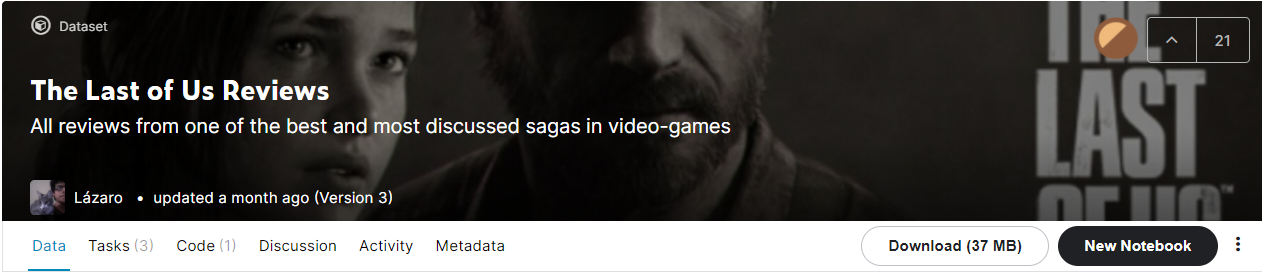

### **Data ชุดนี้มากจากการรีวิวเกมส์ Last of us โดยใช้ web scappingโดยจะตัดออกมาเพียง แค่ ภาคที่2 มาใช้ในการทำ sentiment analysis โดยจะ input review เข้าไปใน model แล้วให้ model ดูว่า review เป็น positive หรือ negative**

# Data Preparation & Exploration

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from wordcloud import WordCloud, STOPWORDS
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
path='../input/the-last-of-us-reviews/'
df=pd.read_csv(path+'user_reviews_g2u.csv')

In [ ]:
df.head()

In [ ]:
df.shape

## Feature ที่ใช้จะใช้แค่ review,laguage กับ score ซึ่งจะเอาไปทำ label 

In [ ]:
df=df[['id','review','language','score']]
df

In [ ]:
df.info()

In [ ]:
dt=df.groupby(['review','id']).size().reset_index().sort_values(by=0,ascending=False)
dt.head(50)

In [ ]:
df.info()

## อาจะมีบาง Review ที่ซ้ำๆกัน โดยดูจากความถี่

In [ ]:
df.drop_duplicates()

## ใช้ Drop_duplicates จัดการ dataที่ซ้ำ

In [ ]:
df=df[df['language']=='English']
df

## ตัดภาษาอื่นออก เอามาเฉพาะแต่ English

In [ ]:
label=[]
for i in df['score']:
  if i >= 5:
     label.append(1)
  else:
    label.append(0)  

In [ ]:
df['label']=label
df

# ให้ 1 เป็น positive review ส่วน 0 เป็น Negative review

In [ ]:
df['label'].value_counts().plot(kind='bar')


In [ ]:
df['label'].value_counts()

## ดู label ว่าเป็น imbalance data หรือไม่ class 1 คิดเป็น 53% ของทั้งหมด

In [ ]:
df_majority=df[df['label']==0]
df_mimority=df[df['label']==1]

In [ ]:
df_majority_down=resample(df_majority,replace=False,n_samples=11365,random_state=9)

In [ ]:
df_majority_down

In [ ]:
df_d=pd.concat([df_majority_down,df_mimority])
df_d['label'].value_counts()

# ทำการ Down sampling 

In [ ]:
df_d

In [ ]:
df=df_d[['review','label']].reset_index(drop=True)

In [ ]:
df

In [ ]:
good_review=" ".join(df_majority['review'].tolist())
bad_review=" ".join(df_mimority['review'].tolist())

In [ ]:

good_review_cloud=WordCloud(stopwords=STOPWORDS,background_color='white').generate(good_review)
bad_review_cloud=WordCloud(stopwords=STOPWORDS,background_color='white').generate(bad_review)

## ลองเอามาสร้าง Wordcloud เพื่อดูคร่าวๆว่าในเเต่ละ review คนพูดถึงอะไรกันมาก

In [ ]:
def show_word_cloud(cloud,title):
  plt.figure(figsize=(16,10))
  plt.imshow(cloud,interpolation='bilinear')
  plt.title(title)
  plt.axis("off")
  plt.show();

In [ ]:
show_word_cloud(good_review_cloud,'Good Reviews words')

In [ ]:
show_word_cloud(bad_review_cloud,'bad Reviews words')

## ทั้งใน positive กับ negative ก็มีคนพูดถึงคำว่า game กับ story แต่ใน negative เหมือนจะพูดถึงตัวละครเอกในภาคนี้ที่ชื่อ Ellie ซึ่งบางที Wordcloud ก็ไม่ทำให้เราได้อะไรมากนัก เพราะ คำที่พูดกันทั้งใน positive และ negative ดันเหมือนๆกัน

In [ ]:

type_one_hot = OneHotEncoder(sparse=False).fit_transform(
  df['label'].to_numpy().reshape(-1, 1)
)

In [ ]:
type_one_hot

## ทำการแปลง label ให้เป็น one hot encoder

In [ ]:
from sklearn.model_selection import train_test_split
train_review,test_review,y_train,y_test=train_test_split(df['review'],type_one_hot,test_size=0.15,random_state=3)

## ทำ Sentence embedding และ ทำการแบ่ง Train/Test

In [ ]:

use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
X_train=[]
for i in tqdm(train_review):
   emb=use([i])   # take input as list
   review_emb=tf.reshape(emb,[-1]).numpy() # after 'use' the result is tensor2D then we reshapre to 1D numpy
   X_train.append(review_emb)

X_train=np.array(X_train)

In [ ]:
X_test=[]
for i in tqdm(test_review):
   emb=use([i])   # takininput as list
   review_emb=tf.reshape(emb,[-1]).numpy() # after 'use' the result is tensor2D then we reshapre to 1D numpy
   X_test.append(review_emb)

X_test=np.array(X_test)

In [ ]:
X_train.shape

## TRAIN MODEL

In [ ]:
model= keras.Sequential()
model.add(keras.layers.Dense(units=256,input_shape=(X_train.shape[1],),activation='relu'
))

model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(2,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(learning_rate=0.001),metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
history=model.fit(X_train,y_train,epochs=10,batch_size=16,validation_split=0.1,verbose=2,shuffle=True)

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss")
plt.legend();

In [ ]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();

In [ ]:
model.evaluate(X_test,y_test)

In [ ]:
y_pred=model.predict_classes(X_test)

In [ ]:
y_actual=np.argmax(y_test,axis=1)

In [ ]:
df_confusion = pd.crosstab(y_actual, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

In [ ]:
pre_0=df_confusion[0][0] / ((df_confusion[0][0]+ df_confusion[0][1]))
print(f'precision class 0 is {pre_0}')

In [ ]:
pre_1=df_confusion[1][1] / ((df_confusion[1][1]+ df_confusion[1][0]))
print(f'precision class 1 is {pre_1}')

In [ ]:
recall_0=df_confusion[0][0] / ((df_confusion[0][0]+ df_confusion[1][0]))
print(f'recall class 0 is {recall_0}')

In [ ]:
recall_1=df_confusion[1][1] / ((df_confusion[1][1]+ df_confusion[0][1]))
print(f'recall class 1 is {recall_1}')

In [ ]:
F1_score_calss0=2*((pre_0*recall_0)/(pre_0+recall_0))
print(f'F1 score calss 0 is {F1_score_calss0}')

In [ ]:
F1_score_calss0=2*((pre_1*recall_1)/(pre_1+recall_1))
print(f'F1 score calss 1 is {F1_score_calss0}')

## Deploy

In [ ]:
print(test_review.iloc[0])
print("Bad" if y_test[0][0] == 1 else "Good") #[1,0] is negative (0)

In [ ]:
y_pred=model.predict(X_test[:1])
print(y_pred)

## ลองจากตัว dataset ที่เทรน ทำนายถูกต้อง แต่ว่าแบบนี้ไม่ควรทำ (การ test ด้ดวย data ที่เททรนมา)

In [ ]:
sentence='I hate this game.Why did you make joel die?'

In [ ]:
sentence_use=use([sentence])

In [ ]:
model.predict(sentence_use)

## จากการลองสุ่มเขียนประโยคเองเป็น Negative ก็จับได้ถูกต้อง แบบด้านบน

In [ ]:
sentence="I love this game so much.Waiting for next episode.But I hate the part of joel's death."
sentence_use=use([sentence])
model.predict(sentence_use)

## พอลองพยายามเขียนกำกวมแบบนี้ดูโมเดลอาจจะยังแยกได้

## ลองเอามาใช้ กับ Dataset ภาค 1

In [ ]:
dt=pd.read_csv(path+'user_reviews_g1u.csv')

In [ ]:
dt=dt[['review','language','score']]

In [ ]:
dt=dt[dt['language']=='English']

In [ ]:
dt

In [ ]:
X=[]
for i in tqdm(dt['review'].to_list()):
   emb=use([i])   
   review_emb=tf.reshape(emb,[-1]).numpy() 
   X.append(review_emb)

X=np.array(X)

In [ ]:
y_pred=model.predict_classes(X)

In [ ]:
label=[]
for i in dt['score']:
  if i >= 5:
     label.append(1)
  else:
    label.append(0)  

In [ ]:
label=np.array(label)

In [ ]:
df_confusion = pd.crosstab(label, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

In [ ]:
print(f'accuracy is {(df_confusion[0][0]+df_confusion[1][1]) / (df_confusion[0][0]+df_confusion[1][1]+df_confusion[0][1]+df_confusion[1][0])}')

# Conclusion

## การใช้ pretrain model ของ tensorflow hubที่ชื่อ universal sentence embedding ทำให้การทำงานด้าน NLP ง่ายขึ้น ไม่ต้องเทรนหลายๆรอบ และ ตัว Model ที่ได้มาจากการเทรน แค่ Dataset ในภาค 2 ก็ย้อนกลับเอาไปใช้ในภาค 1 ได้เพราะว่า อยู่ใน Domain เดียวกัน หากเอาไปใช้ข้าม Domain ความแม่นยำก็จะลดลงไปอย่างมาก (ซึ่งแอบเอาไปลองเล่นมาแล้ว)